# Effects of Flight Characteristics on Delay Frequencies and Duration

### Investigation and Dataset Overview 

The goal of this analysis was to identify factors contributing to flight delays. The dataset used was flight data for American-based airlines and flights for 2008. The dataset contained both delayed and on-time flights, but different sub-sects of the dataset were used for the analysis when specified below. 

***All delays shown are in minutes***


### Import & Clean Data

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sb
%matplotlib inline

In [2]:
df = pd.read_csv('data/flight_data.csv')

In [14]:
df.head()

,Month,DayofMonth,DayOfWeek,actual_depart,sched_depart,actual_arrival,sched_arrival,UniqueCarrier,AirTime,ArrDelay,...,TaxiOut,Cancelled,CancellationCode,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,total_delay,new_col
0,1,3,Thursday,2003.0,1955,2211.0,2225,WN,116.0,-14.0,...,8.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,3,Thursday,754.0,735,1002.0,1000,WN,113.0,2.0,...,10.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,1,3,Thursday,628.0,620,804.0,750,WN,76.0,14.0,...,17.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,1,3,Thursday,926.0,930,1054.0,1100,WN,78.0,-6.0,...,7.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,1,3,Thursday,1829.0,1755,1959.0,1925,WN,77.0,34.0,...,10.0,0,NaN,2.0,0.0,0.0,0.0,32.0,34.0,5


In [3]:
#rename columns so they are easier to interpret 

df = df.rename(columns = {'CRSDepTime':'sched_depart',
                    'DepTime':'actual_depart',
                    'ArrTime':'actual_arrival',
                    'CRSArrTime':'sched_arrival'
                    })

In [4]:
#replace encodings with actual values 

df.CancellationCode = df.CancellationCode.replace({'A':'carrier',
                                                   'B':'weather',
                                                  'C':'NAS',
                                                  'D':'security'})

In [5]:
#change datatype to string 

df.DayOfWeek = df.DayOfWeek.astype('str')
# df.Month = df.Month.astype('str')

#replace encodings with actual values 

df.DayOfWeek = df.DayOfWeek.replace({'1':'Monday',
                     '2':'Tuesday',
                     '3':'Wednesday',
                     '4':'Thursday',
                     '5':'Friday',
                     '6':'Saturday',
                     '7':'Sunday'})

In [6]:
#put days of week in order

ordinal_var_dict = {'DayOfWeek': ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']}
for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)
    
    

In [7]:
#drop columns not necessary for analysis
df = df.drop(columns=['Year','FlightNum','TailNum','ActualElapsedTime','CRSElapsedTime','Diverted'])

In [8]:
df['total_delay']= df['CarrierDelay']+df['WeatherDelay']+df['SecurityDelay']+df['LateAircraftDelay']

In [9]:
#add dummy index column to create unique identifier for melt function 

df['new_col'] = range(1, len(df) + 1)

In [15]:
df_new = pd.melt(df, 
                 id_vars=['Month','DayofMonth','DayOfWeek','actual_depart','sched_depart','actual_arrival','sched_arrival','UniqueCarrier','AirTime','ArrDelay','DepDelay','Origin','Dest','Distance','TaxiIn','TaxiOut','Cancelled','CancellationCode','total_delay','new_col'],
                 value_vars = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay','LateAircraftDelay'],
                 var_name='types',value_name='delay_type')
                          

In [11]:
#sort values by type and then drop duplicates
df_new = df_new.sort_values('delay_type').drop_duplicates('new_col', keep = 'last')

In [12]:
#drop unnecessary column
df_new = df_new.drop(columns=['delay_type','new_col'])

In [13]:
#create df to only include delays (exlude where delays are 0)
df_delays = df.loc[df['total_delay']>0]

### Arrival vs Departure Delays

It is interesting to look at the distribution of departure delays vs. the distribution of arrival delays as they are quite different. The distribution of arrival delays is distinctly right-skewed, while departure delays are more evenly distributed. Both are uni-modal. 

It appears that arrival delays are never less than 10 minutes. This leads me to believe that perhaps arrivals less than 10 minutes past the scheduled arrival time are not considered delays at all. The median length of an arrival delay is approx. 25 minutes, compared to 40 minutes for a departure delay. 

For this analysis a new df was created including only flight records with delays. 


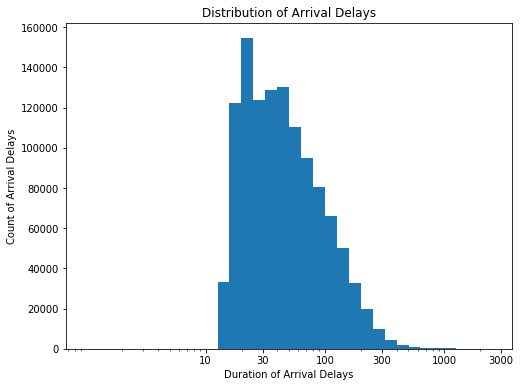

In [47]:
#distribution of arrival delays

bins = 10 ** np.arange(0,np.log10(df_delays.ArrDelay.max())+.1,.1)

plt.figure(figsize = [8,6])
plt.hist(df_delays.ArrDelay,bins=bins)
plt.xscale('log')
tick_locs = [10, 30, 100, 300, 1000, 3000]
plt.xticks(tick_locs, tick_locs)
plt.xlabel('Duration of Arrival Delays')
plt.ylabel('Count of Arrival Delays')
plt.title('Distribution of Arrival Delays');

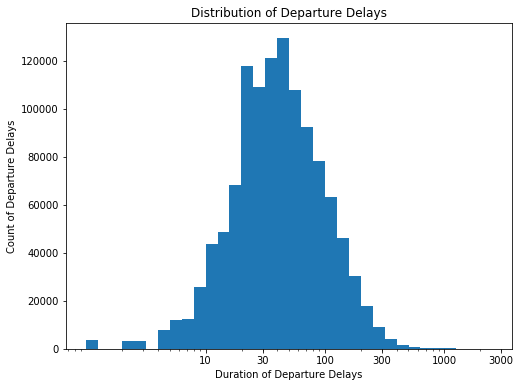

In [48]:
#distribution of departure delays

bins = 10 ** np.arange(0,np.log10(df_delays.DepDelay.max())+.1,.1)

plt.figure(figsize = [8,6])
plt.hist(df_delays.DepDelay,bins=bins)
plt.xscale('log')
tick_locs = [10, 30, 100, 300, 1000, 3000]
plt.xticks(tick_locs, tick_locs)
plt.xlabel('Duration of Departure Delays')
plt.ylabel('Count of Departure Delays')
plt.title('Distribution of Departure Delays');

### Types of Delays

An analysis of delays by type shows that the most frequent delays are late aircraft delays (more than 10x higher than other categories).

We can see that the distributions for all delay types are right skewed which is not surprising. By looking at the scatterplots, we see that the longest delays are attributed to carrier delays, followed closely by late aircraft and weather delays.

Overall, weather delays are far less frequent and shorter than I would have thought, especially as this data is for the USA which experiences harsh winters in many areas.

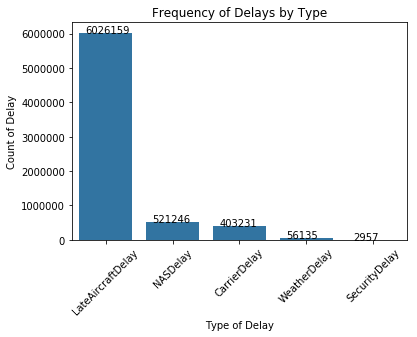

In [49]:
# labels = ['6,026,159','521,246','403,231','56,135','2,957']

gen_order = df_new.types.value_counts().index

base_color = sb.color_palette()[0]
ax = sb.countplot(data=df_new,x='types', color=base_color, order= gen_order)
plt.xticks(rotation=45)
plt.xlabel('Type of Delay')
plt.ylabel('Count of Delay')
plt.title('Frequency of Delays by Type')
for p, label in zip(ax.patches, df_new["types"].value_counts()):
    ax.annotate(label, (p.get_x()+.1, p.get_height()+0.15));

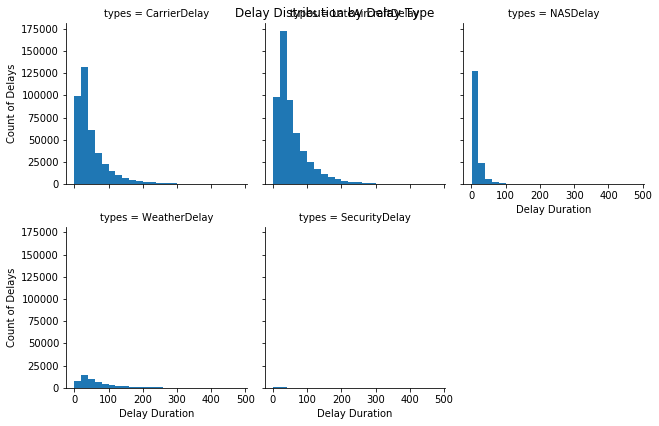

In [50]:
bins = np.arange(0.1,500,20)
g = sb.FacetGrid(data=df_new, col='types', col_wrap=3)
g.map(plt.hist, 'total_delay', bins=bins)
g.set_xlabels('Delay Duration')
g.set_ylabels('Count of Delays')
g.fig.suptitle('Delay Distribution by Delay Type')
plt.show();

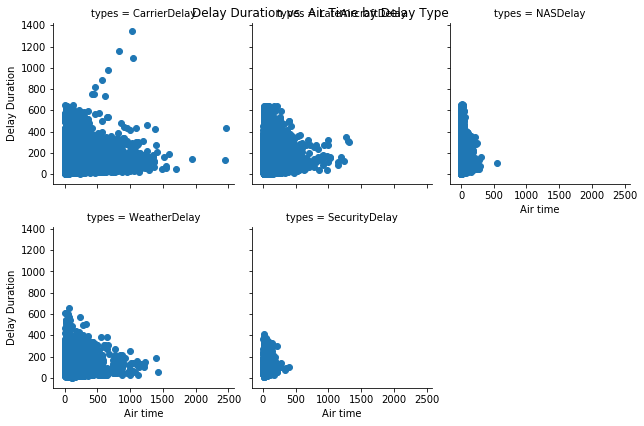

In [51]:
g = sb.FacetGrid(data=df_new, col='types',col_wrap=3)
g.map(plt.scatter, 'total_delay','AirTime')
g.set_xlabels('Air time')
g.set_ylabels('Delay Duration')
g.fig.suptitle('Delay Duration vs. Air Time by Delay Type')
plt.show();

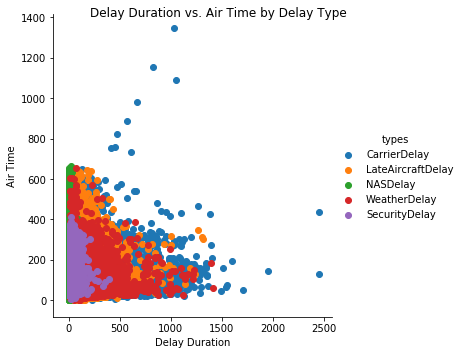

In [52]:
g = sb.FacetGrid(data = df_new, hue = 'types', height = 5)
g.map(plt.scatter, 'total_delay','AirTime' )
g.add_legend()
g.set_xlabels('Delay Duration')
g.set_ylabels('Air Time')
g.fig.suptitle('Delay Duration vs. Air Time by Delay Type');

### Analysis by Carrier

Can see that carrier WN (Southwest) has most frequent delays, but not the highest proportionate delays. American Airlines (AA) ranks quite high proportionately, and from a frequency standpoint. United Airlines has the second highest proportion of flight delays at just under 20%. This is ironic as I am currently sitting in an airport completing this project, and have just discovered my UA flight has been delayed. 

The scatter plots highlight that carrier HA has the longest flight time, while carrier NW has the longest delays.

Proportionately, AA has the most delays (overall this may be the worst airline in terms of delays judging by the frequency and length of the delays).

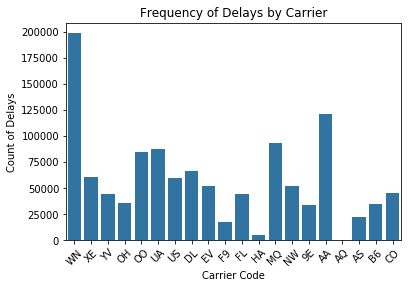

In [53]:
base_color = sb.color_palette()[0]
sb.countplot(data=df_delays,x='UniqueCarrier', color=base_color)
plt.xticks(rotation=45)
plt.xlabel('Carrier Code')
plt.ylabel('Count of Delays')
plt.title('Frequency of Delays by Carrier');


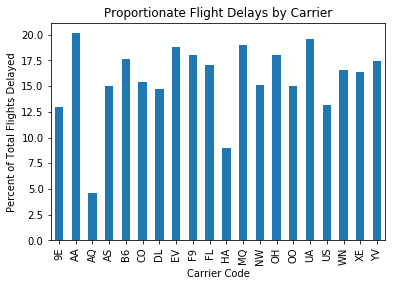

In [54]:
#number of delays as a % of total flights by carrier

total_flights = df.UniqueCarrier.value_counts()
delayed_flights = df_delays.UniqueCarrier.value_counts()
percent_delayed = (delayed_flights/total_flights)*100

base_color = sb.color_palette()[0]
percent_delayed.plot(kind='bar',color=base_color);
plt.xlabel('Carrier Code')
plt.ylabel('Percent of Total Flights Delayed')
plt.title('Proportionate Flight Delays by Carrier');

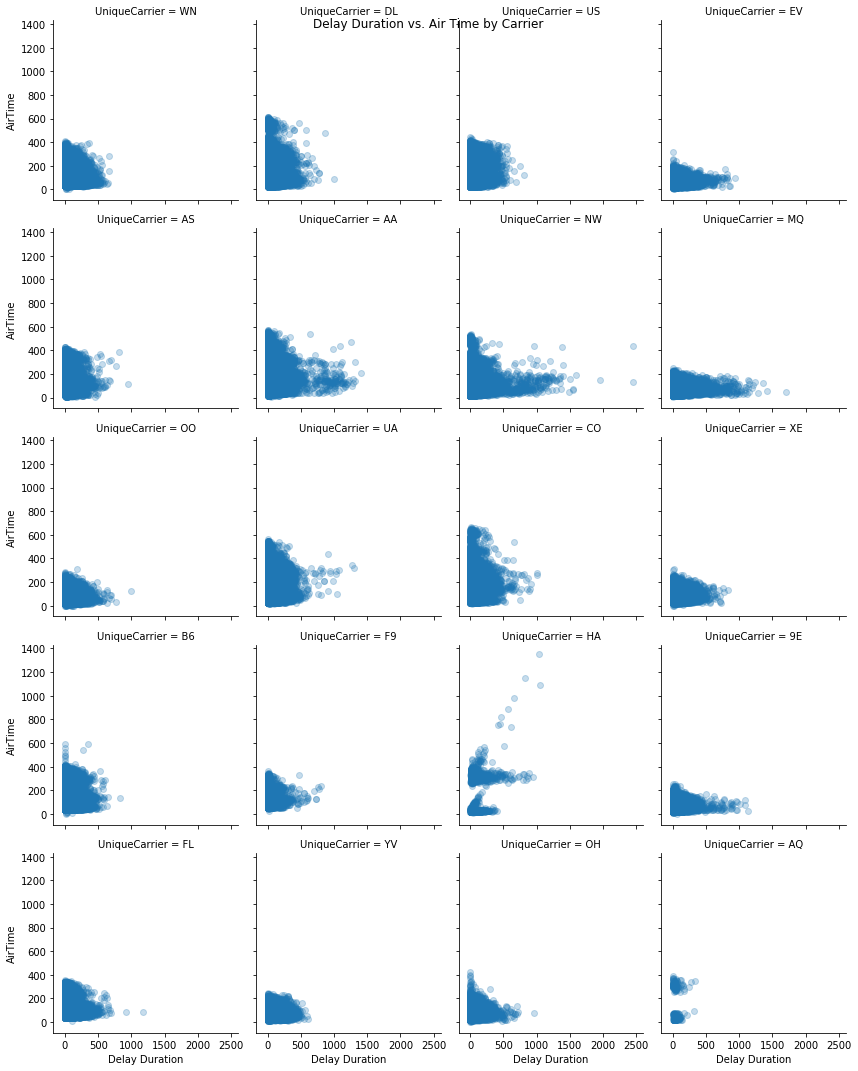

In [55]:
g = sb.FacetGrid(data=df_new, col='UniqueCarrier', col_wrap=4)
g.map(plt.scatter, 'total_delay','AirTime',alpha= .25)
g.set_xlabels('Delay Duration')
g.set_ylabels('AirTime')
g.fig.suptitle('Delay Duration vs. Air Time by Carrier')
plt.show();

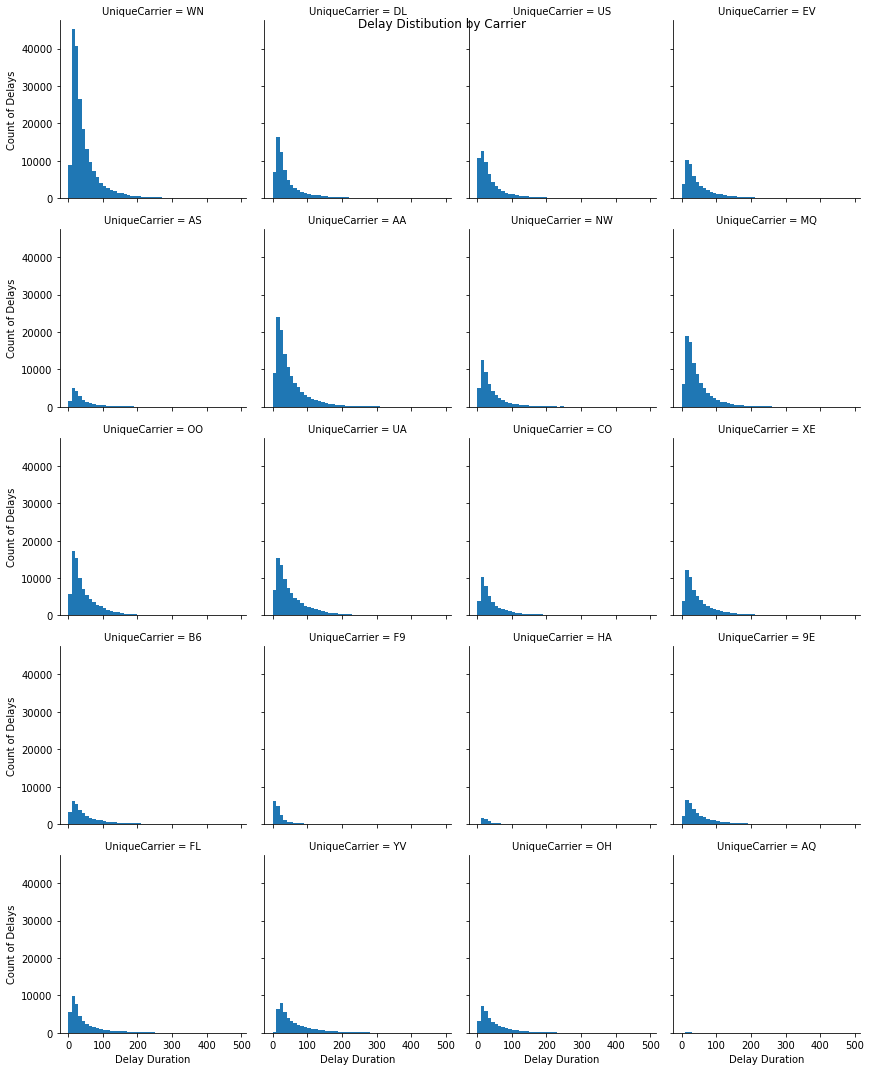

In [56]:
#distribution of delays by carrier

bins = np.arange(0.1,500,10)
g = sb.FacetGrid(data=df_new, col='UniqueCarrier', col_wrap=4)
g.map(plt.hist, 'total_delay',bins=bins)
g.set_xlabels('Delay Duration')
g.set_ylabels('Count of Delays')
g.fig.suptitle('Delay Distibution by Carrier')
plt.show();

### Analysis by Origin & Destination

Created a new df of delays with value counts of greater than 15,000 for both origin airports and departure airports to make visuals interpretable. 

We can see that the majority of delays are for flights originating from Atlanta (ATL) and Chicago (ORD), followed by Dallas (DFW). In analyzing delays by departure airport, I was surprised to see that Atlanta and Chicago are the most frequent offenders for delays in this respect as well. 



In [57]:
#create new df of origins with value counts > 15,0000 to analyze most frequent origin of delays

df_origin = df_delays.groupby("Origin").filter(lambda x: len(x) > 15000)

#do the same for destinations

df_dest = df_delays.groupby("Dest").filter(lambda x: len(x) > 15000)

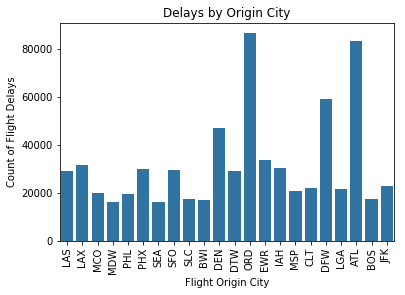

In [58]:
base_color = sb.color_palette()[0]

sb.countplot(data = df_origin, x='Origin', color=base_color)
plt.xticks(rotation=90)
plt.xlabel('Flight Origin City')
plt.ylabel('Count of Flight Delays')
plt.title('Delays by Origin City');

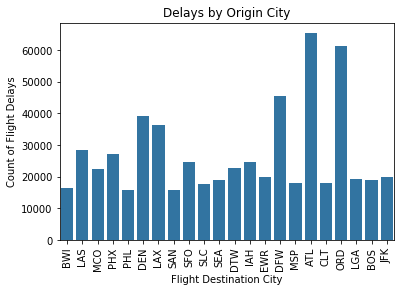

In [59]:
base_color = sb.color_palette()[0]

sb.countplot(data = df_dest, x='Dest', color=base_color)
plt.xticks(rotation=90)
plt.xlabel('Flight Destination City')
plt.ylabel('Count of Flight Delays')
plt.title('Delays by Origin City');

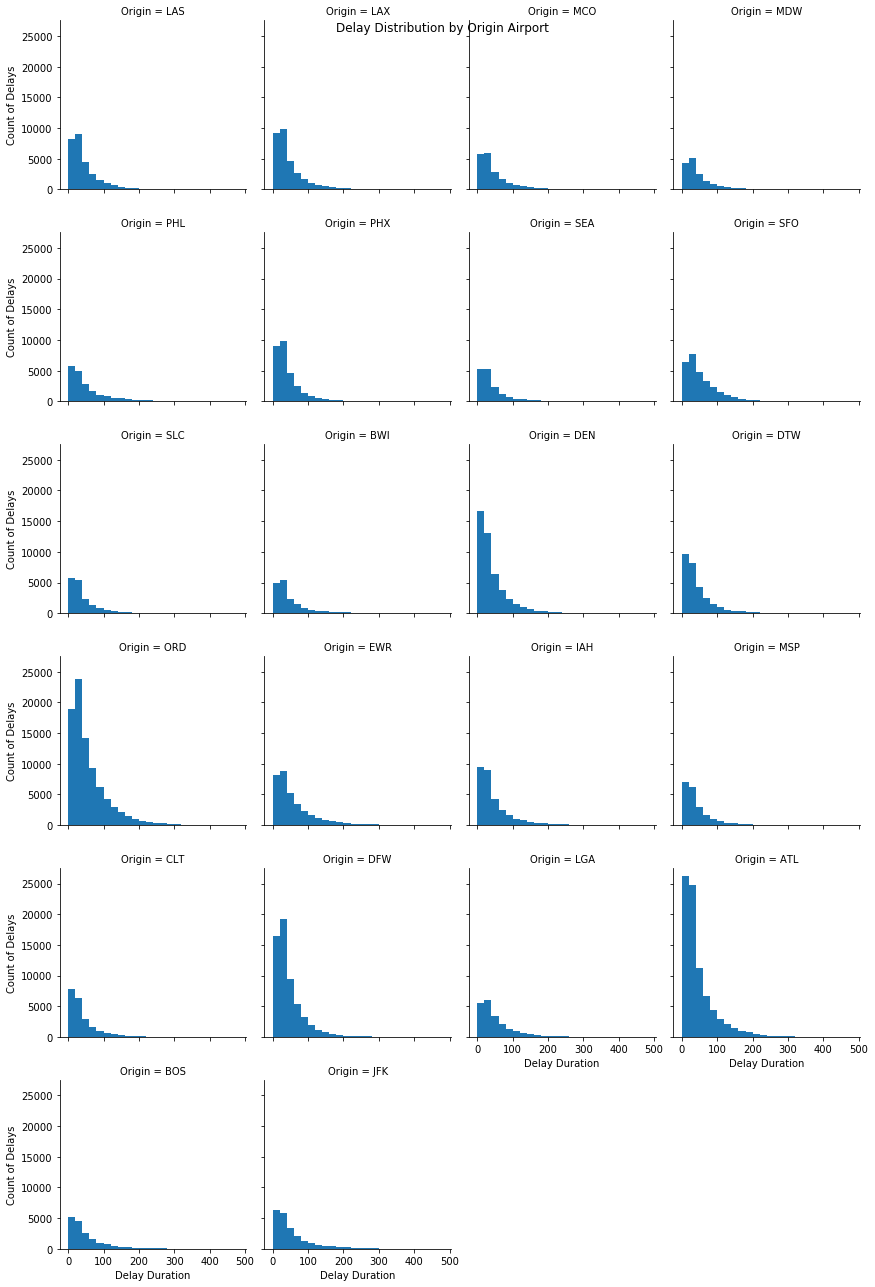

In [60]:
#distribution of delays by Origin

bins = np.arange(0.1,500,20)
g = sb.FacetGrid(data=df_origin, col='Origin', col_wrap=4)
g.map(plt.hist, 'total_delay',bins=bins)
g.set_xlabels('Delay Duration')
g.set_ylabels('Count of Delays')
g.fig.suptitle('Delay Distribution by Origin Airport')
plt.show();

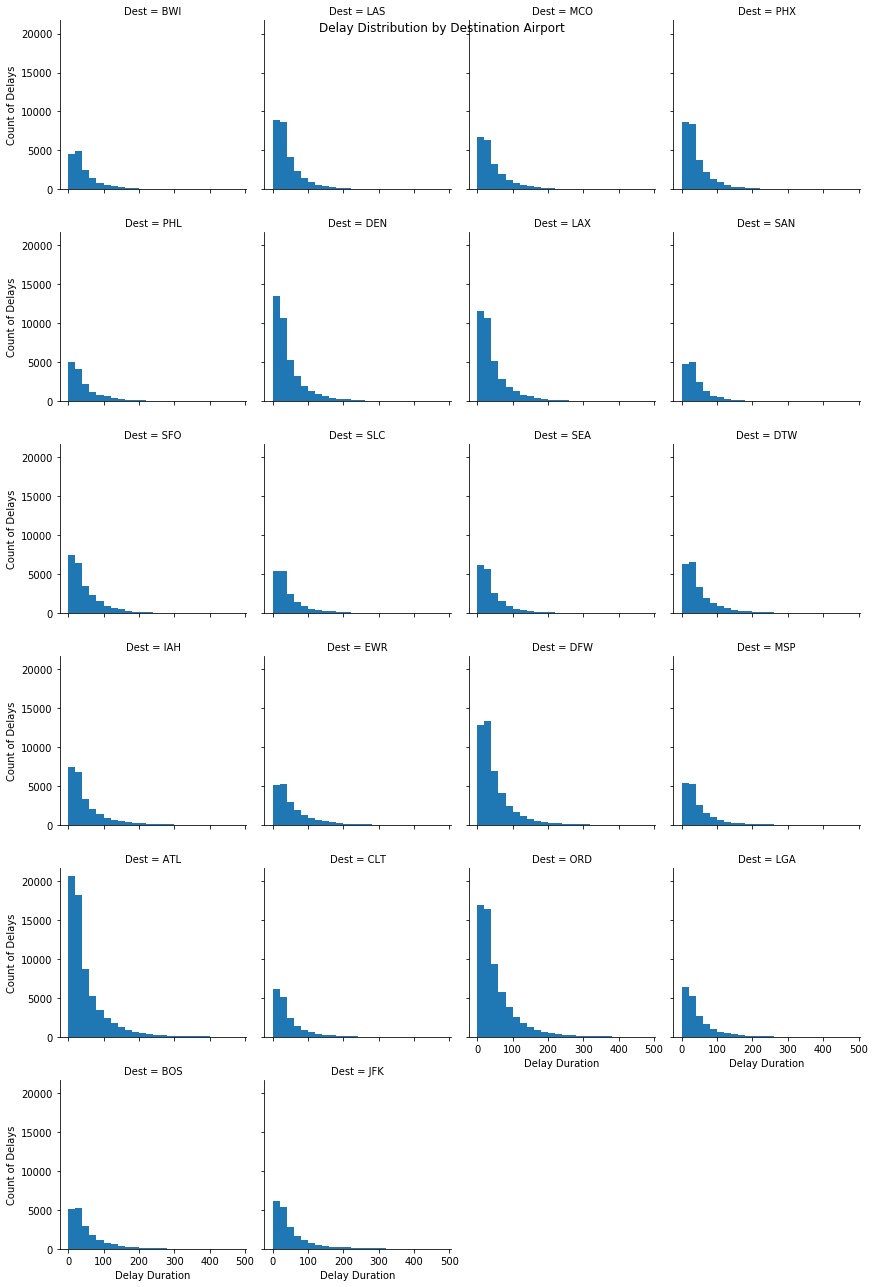

In [61]:
#distribution of delays by Destination

bins = np.arange(0.1,500,20)
g = sb.FacetGrid(data=df_dest, col='Dest', col_wrap=4)
g.map(plt.hist, 'total_delay',bins=bins)
g.set_xlabels('Delay Duration')
g.set_ylabels('Count of Delays')
g.fig.suptitle('Delay Distribution by Destination Airport')
plt.show();

### Analysis by Time of Year / Day of Week

I was not surprised to see that the most delays occured on a Friday, as this is likely business travellers returning home, and vacationers leaving for weekend trips. I also was not surprised to see that the majority of delays occured in December, likely to weather related issues.

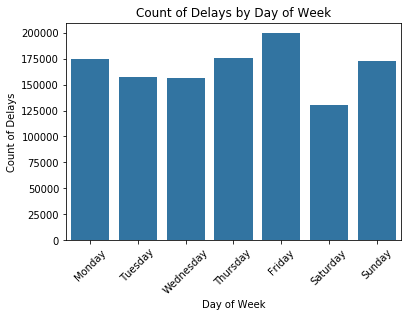

In [62]:
base_color = sb.color_palette()[0]

sb.countplot(data = df_delays, x='DayOfWeek', color=base_color)
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Count of Delays')
plt.title('Count of Delays by Day of Week');

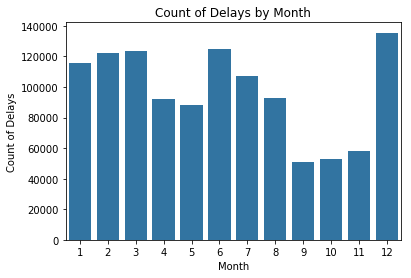

In [63]:
base_color = sb.color_palette()[0]

sb.countplot(data = df_delays, x='Month', color=base_color)
plt.xlabel('Month')
plt.ylabel('Count of Delays')
plt.title('Count of Delays by Month'); 